===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html


In [1]:
from time import time
import logging
import pylab as pl
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [3]:
##############################################################################
# Download the data, if not already on disk and load it as numpy arrays
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [5]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

In [6]:
# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

In [7]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [8]:
###############################################################################
# Split into a training and testing set
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
from sklearn.decomposition import RandomizedPCA

n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


Extracting the top 150 eigenfaces from 966 faces
done in 6.418s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.474s


In [31]:
###############################################################################
# Train a SVM classification model
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 41.749s
Best estimator found by grid search:
SVC(C=5000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [32]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

Predicting the people names on the testing set
done in 0.014s


In [33]:
print classification_report(y_test, y_pred, target_names=target_names)

                   precision    recall  f1-score   support

     Ariel Sharon       0.08      0.15      0.10        13
     Colin Powell       0.35      0.37      0.36        60
  Donald Rumsfeld       0.14      0.26      0.18        27
    George W Bush       0.65      0.46      0.54       146
Gerhard Schroeder       0.12      0.16      0.14        25
      Hugo Chavez       0.08      0.07      0.07        15
       Tony Blair       0.30      0.31      0.30        36

      avg / total       0.42      0.35      0.38       322



In [20]:
print confusion_matrix(y_test, y_pred, labels=range(n_classes))

[[ 10   1   0   1   0   1   0]
 [  2  51   0   4   0   3   0]
 [  2   3  19   3   0   0   0]
 [  3   8   4 127   0   1   3]
 [  0   3   2   4  13   1   2]
 [  1   2   0   0   0  12   0]
 [  0   4   4   1   3   0  24]]


In [12]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

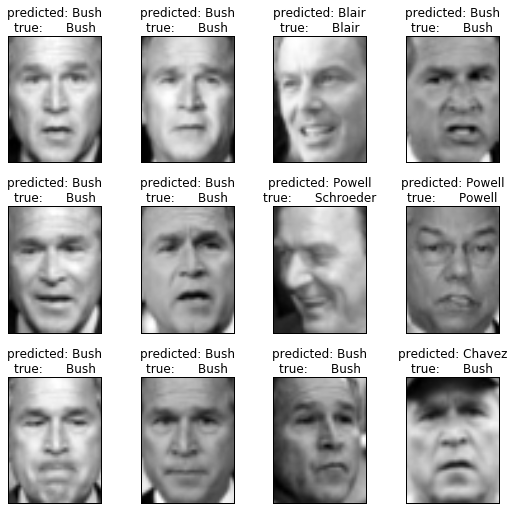

In [13]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

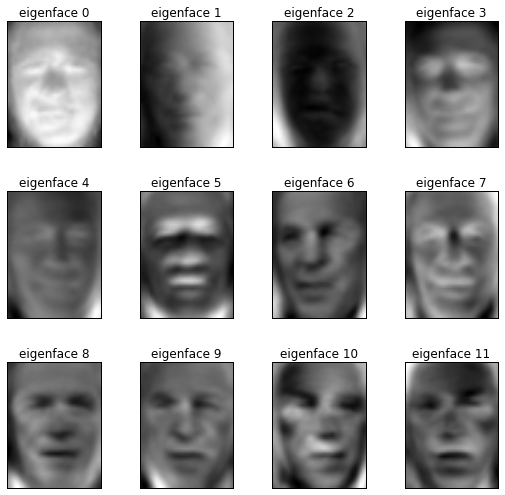

In [14]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

We mentioned that PCA will order the principal components, with the first PC giving the direction of maximal variance, second PC has second-largest variance, and so on. __How much of the variance is explained by the first principal component?__  __The second?__

In [17]:
print(pca.explained_variance_ratio_[[0, 1]])

[ 0.18758923  0.15309102]


Now you'll experiment with keeping different numbers of principal components. In a multiclass classification problem like this one (more than 2 labels to apply), accuracy is a less-intuitive metric than in the 2-class case. Instead, a popular metric is the F1 score.

We’ll learn about the F1 score properly in the lesson on evaluation metrics, but you’ll figure out for yourself whether a good classifier is characterized by a high or low F1 score. You’ll do this by varying the number of principal components and watching how the F1 score changes in response.

__As you add more principal components as features for training your classifier, do you expect it to get better or worse performance?__



Change n_components to the following values: [10, 15, 25, 50, 100, 250]. For each number of principal components, note the F1 score for Ariel Sharon. (For 10 PCs, the plotting functions in the code will break, but you should be able to see the F1 scores.) If you see a higher F1 score, does it mean the classifier is doing better, or worse?

Do you see any evidence of overfitting when using a large number of PCs? Does the dimensionality reduction of PCA seem to be helping your performance here?